# Important!

In [1]:
# Following this tutorial: https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
# TODO: This tutorial has enhancements: https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report

In [2]:
# read data
df = pd.read_csv('raw_data/fulltrain.csv', names=['labels', 'text'])
test_df = pd.read_csv('raw_data/balancedtest.csv', names=['labels', 'text'])
df.head()

,labels,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [3]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = str(text).replace(r'http[\w:/\.]+','') # removing urls
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

df['text'] = df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [4]:
# create x and y
X = df['text']
y = df['labels']

# test x and y
X_test = test_df['text']
y_test = test_df['labels']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
my_tags = ['trusted', 'satire', 'hoax', 'propaganda']

# Naive Bayes (NB)

In [179]:
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

print('VALIDATION SET')
y_pred = nb.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred, target_names=my_tags))


print('TEST SET')
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

VALIDATION SET
accuracy 0.7886334174797025
              precision    recall  f1-score   support

     trusted       0.83      0.86      0.85      4244
      satire       1.00      0.40      0.57      2065
        hoax       0.69      0.99      0.82      5313
  propaganda       0.99      0.59      0.74      3035

    accuracy                           0.79     14657
   macro avg       0.88      0.71      0.74     14657
weighted avg       0.84      0.79      0.77     14657

TEST SET
accuracy 0.511
              precision    recall  f1-score   support

     trusted       0.69      0.61      0.65       750
      satire       0.50      0.01      0.02       750
        hoax       0.37      1.00      0.54       750
  propaganda       0.98      0.43      0.59       750

    accuracy                           0.51      3000
   macro avg       0.64      0.51      0.45      3000
weighted avg       0.64      0.51      0.45      3000



# Support Vector Machine (SVM)

In [52]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Find optimal hyperparams and score using GridSearchCV
parameters = {
            #   'tfidf__ngram_range': [(1, 1), (1, 2)],
            #   'tfidf__use_idf': (True, False),
            #   'tfidf__sublinear_tf': (True, False),
            #   'tfidf__stop_words' : (None, "english"),
            #   'tfidf__norm': ('l2', 'l1'),
            #   'clf__class_weight': ('none', "balanced", "auto"),
            #   'clf__penalty': ['none', 'l2'],
            #   'clf__loss': ['hinge', 'log_loss'],
}

# sgd = Pipeline([('tfidf', TfidfVectorizer()),
#                    ('clf', LogisticRegression()),
#                   ])
# sgd.fit(X_train, y_train)
# gs_clf = GridSearchCV(sgd, parameters, n_jobs=-1, scoring='f1_macro', cv=10)
# gs_clf = gs_clf.fit(X_train, y_train)
# print(gs_clf.best_params_)
# print(gs_clf.best_score_)
               
# Use optimal hyperparams derived from GridSearchCV
sgd = Pipeline([('tfidf', TfidfVectorizer(norm='l2', ngram_range=(1,2), sublinear_tf=True, stop_words='english')),
                ('clf', SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced')),
               ])
sgd.fit(X_train, y_train)

print('VALIDATION SET')
y_pred = sgd.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred,target_names=my_tags))


print('TEST SET')
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

VALIDATION SET
accuracy 0.9541515999181278
              precision    recall  f1-score   support

     trusted       0.93      0.97      0.95      4244
      satire       0.95      0.97      0.96      2065
        hoax       0.97      0.97      0.97      5313
  propaganda       0.96      0.91      0.93      3035

    accuracy                           0.95     14657
   macro avg       0.95      0.95      0.95     14657
weighted avg       0.95      0.95      0.95     14657

TEST SET
accuracy 0.7663333333333333
              precision    recall  f1-score   support

     trusted       0.84      0.78      0.81       750
      satire       0.77      0.52      0.62       750
        hoax       0.67      0.88      0.76       750
  propaganda       0.82      0.88      0.85       750

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.76      3000
weighted avg       0.77      0.77      0.76      3000



# Logistic Regression (LR)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Find optimal hyperparams and score using GridSearchCV
parameters = {
              'tfidf__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'tfidf__sublinear_tf': (True, False),
              'tfidf__stop_words' : (None, "english"),
              'tfidf__norm': ('l2', 'l1'),
              'clf__class_weight': ('none', "balanced", "auto"),
              'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
              'clf__penalty': ['none','l2'],
              'clf__C': np.logspace(-3,3,7),
}

# logreg = Pipeline([('tfidf', TfidfVectorizer()),
#                    ('clf', LogisticRegression()),
#                   ])
# logreg.fit(X_train, y_train)
# gs_clf = GridSearchCV(logreg, parameters, n_jobs=-1, scoring='f1_macro', cv=10)
# gs_clf = gs_clf.fit(X_train, y_train)
# print(gs_clf.best_params_)
# print(gs_clf.best_score_)

# # Use optimal hyperparams derived from GridSearchCV
logreg = Pipeline([('tfidf', TfidfVectorizer(norm='l2', ngram_range=(1,2), sublinear_tf=True, stop_words='english')),
                   ('clf', LogisticRegression(class_weight="balanced", solver="liblinear", penalty="l2", C=1000.0)),
                  ])
logreg.fit(X_train, y_train)

print('VALIDATION SET')
y_pred = logreg.predict(X_val)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred, target_names=my_tags))


print('TEST SET')
y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

VALIDATION SET
accuracy 0.9697073070887631
              precision    recall  f1-score   support

     trusted       0.97      0.97      0.97      4244
      satire       0.97      0.97      0.97      2065
        hoax       0.97      0.98      0.98      5313
  propaganda       0.96      0.95      0.96      3035

    accuracy                           0.97     14657
   macro avg       0.97      0.97      0.97     14657
weighted avg       0.97      0.97      0.97     14657

TEST SET
accuracy 0.767
              precision    recall  f1-score   support

     trusted       0.88      0.79      0.83       750
      satire       0.78      0.51      0.62       750
        hoax       0.66      0.84      0.74       750
  propaganda       0.79      0.93      0.85       750

    accuracy                           0.77      3000
   macro avg       0.78      0.77      0.76      3000
weighted avg       0.78      0.77      0.76      3000



In [8]:
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from PIL import Image 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [9]:
def draw_confusion_matrix(true, preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(
        conf_matx, 
        annot=True, 
        annot_kws={"size": 12},
        fmt='g', 
        cbar=False, 
        cmap="viridis"
    )
    plt.show()

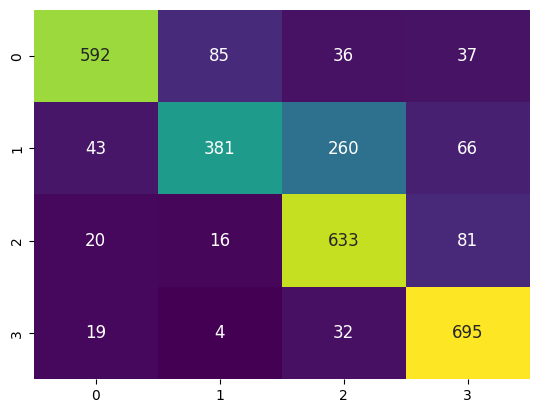

In [11]:
draw_confusion_matrix(y_test, y_pred)

## Subsection: Generating explainer coefficients for logistic regression

In [41]:
logreg['clf'].coef_.shape

(4, 5721647)

In [13]:
logreg['clf'].intercept_[0]

-1.719518739131721

In [35]:
vectorizer = TfidfVectorizer(norm='l2', ngram_range=(1,2), sublinear_tf=True, stop_words='english')
vectorized = vectorizer.fit_transform(X_train)

In [38]:
features = vectorizer.get_feature_names_out()

In [37]:
vectorized.shape

(34197, 5721647)

In [88]:
y_test_proba = logreg.predict_proba(X_test)

In [89]:
sorted_proba = list(zip(range(750), y_test_proba[:751]))
sorted_proba.sort(key=lambda x:x[1][0], reverse=True)
sorted_proba

[(741,
  array([9.99908323e-01, 3.31856823e-05, 1.63077072e-05, 4.21837861e-05])),
 (252,
  array([9.99758710e-01, 6.46781152e-05, 1.20327941e-05, 1.64579095e-04])),
 (278,
  array([9.99719087e-01, 2.84611221e-05, 1.98797898e-04, 5.36538380e-05])),
 (16, array([9.99660175e-01, 2.70885641e-04, 2.35531445e-05, 4.53861639e-05])),
 (154,
  array([9.99620342e-01, 2.94703131e-04, 8.41872495e-05, 7.67944182e-07])),
 (517,
  array([9.99615497e-01, 1.66537835e-04, 6.78269151e-06, 2.11182467e-04])),
 (353,
  array([9.99568685e-01, 1.22471512e-05, 3.41590842e-04, 7.74773108e-05])),
 (166,
  array([9.99554666e-01, 3.27173319e-04, 1.00409214e-04, 1.77515644e-05])),
 (205,
  array([9.99482493e-01, 4.95623114e-04, 1.54650043e-05, 6.41895710e-06])),
 (394,
  array([9.99470283e-01, 1.99743349e-04, 1.59197106e-05, 3.14054066e-04])),
 (526,
  array([9.99469727e-01, 2.82242039e-04, 1.69181127e-04, 7.88503005e-05])),
 (536,
  array([9.99430864e-01, 4.42885608e-04, 9.17210658e-07, 1.25332897e-04])),
 (348,


In [101]:
len(nltk.word_tokenize(X_test[252]))

94

In [46]:
# NOTE vary the index of the coef from 0 to 3

feat_list = []
total_importance = 0
# Make a dataframe of Coefficients and Feature Names
for feature in zip(features, logreg['clf'].coef_[0]):
    feat_list.append(feature)
    total_importance += feature[1]

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'COEFFICIENT']).sort_values(by='COEFFICIENT', ascending=False)
# df_imp.sort_values(by='IMPORTANCE', ascending=False)
df_imp


,FEATURE,COEFFICIENT
5015753,taiwan,38.159626
3717732,percent,34.285318
4428423,said,33.318412
5553542,wednesday,28.885243
5152891,thursday,28.200533
...,...,...
4261751,reports,-20.374504
4751211,sources,-22.011829
435225,articles,-23.075236
432174,article,-24.233906


In [47]:
df_imp.to_csv("log_reg_explainer_label1.csv")

In [69]:
label_features = pd.read_csv("log_reg_explainer_label1.csv")

In [102]:
label_features.head(10)

,Unnamed: 0,FEATURE,COEFFICIENT
0,4428423,said,80.946442
1,3294672,monday,65.653810
2,205920,added,49.122618
3,4256311,reportedly,38.718098
4,3922634,press time,36.120642
5,211063,adding,34.219866
6,4751211,sources,33.991887
7,1130406,confirmed,30.627810
8,5285440,tuesday,27.459284
9,3921374,press,26.439325


In [71]:
label_features.tail(10)

,Unnamed: 0,FEATURE,COEFFICIENT
5721637,61061,2009,-17.642644
5721638,3828759,police,-18.935765
5721639,4477108,says,-19.881075
5721640,2236762,government,-23.170946
5721641,3869191,post,-23.477223
5721642,5271875,trump,-24.502426
5721643,3487725,obama,-26.073189
5721644,5015753,taiwan,-26.090014
5721645,5442370,video,-26.122702
5721646,5126235,think,-30.204122


# Word2Vec + LR

In [173]:
# load word vectors 
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("./word_vec/GoogleNews-vectors-negative300.bin", binary=True)
wv.init_sims(replace=True)

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.vectors[wv.key_to_index[word]])
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list])
    
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

train_tokenized = X_train.apply(lambda r: w2v_tokenize_text(r)).values
val_tokenized = X_val.apply(lambda r: w2v_tokenize_text(r)).values
test_tokenized = X_test.apply(lambda r: w2v_tokenize_text(r)).values

X_train_word_average = word_averaging_list(wv, train_tokenized)
X_val_word_average = word_averaging_list(wv, val_tokenized)
X_test_word_average = word_averaging_list(wv, test_tokenized)

/var/folders/sx/07cm72r10wsb6gt_3x9rvgkm0000gn/T/ipykernel_4633/1027683224.py:4: DeprecationWarning: Call to deprecated `init_sims` (Use fill_norms() instead. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  wv.init_sims(replace=True)


In [174]:
logreg = LogisticRegression(random_state=0, max_iter=10000)
logreg = logreg.fit(X_train_word_average, y_train)

print('VALIDATION SET')
y_pred = logreg.predict(X_val_word_average)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred, target_names=my_tags))


print('TEST SET')
y_pred = logreg.predict(X_test_word_average)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

VALIDATION SET
accuracy 0.8795114962134134
              precision    recall  f1-score   support

     trusted       0.86      0.89      0.88      4244
      satire       0.88      0.81      0.85      2065
        hoax       0.89      0.94      0.91      5313
  propaganda       0.88      0.80      0.84      3035

    accuracy                           0.88     14657
   macro avg       0.88      0.86      0.87     14657
weighted avg       0.88      0.88      0.88     14657

TEST SET
accuracy 0.6783333333333333
              precision    recall  f1-score   support

     trusted       0.75      0.69      0.71       750
      satire       0.65      0.40      0.49       750
        hoax       0.57      0.86      0.68       750
  propaganda       0.81      0.77      0.79       750

    accuracy                           0.68      3000
   macro avg       0.69      0.68      0.67      3000
weighted avg       0.69      0.68      0.67      3000



Seems like it was pretty bad... in that case, we shall try...

# Doc2Vec + LR

In [133]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

X_train_labelled = label_sentences(X_train, 'Train')
X_val_labelled = label_sentences(X_val, 'Val')
all_data_train_val = X_train_labelled + X_val_labelled

X_test_labelled = label_sentences(X_test, 'Test')
all_data_train_test = X_train_labelled + X_test_labelled

In [135]:
model_dbow_train_val = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow_train_val.build_vocab([x for x in tqdm(all_data_train_val)])

for epoch in range(10):
    print(epoch)
    model_dbow_train_val.train(utils.shuffle([x for x in tqdm(all_data_train_val)]), total_examples=len(all_data_train_val), epochs=1)
    model_dbow_train_val.alpha -= 0.002
    model_dbow_train_val.min_alpha = model_dbow_train_val.alpha

model_dbow_train_test = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow_train_test.build_vocab([x for x in tqdm(all_data_train_test)])

for epoch in range(10):
    print(epoch)
    model_dbow_train_test.train(utils.shuffle([x for x in tqdm(all_data_train_test)]), total_examples=len(all_data_train_test), epochs=1)
    model_dbow_train_test.alpha -= 0.002
    model_dbow_train_test.min_alpha = model_dbow_train_test.alpha


100%|██████████| 48854/48854 [00:00<00:00, 923585.51it/s]


0


100%|██████████| 48854/48854 [00:00<00:00, 1932880.50it/s]


1


100%|██████████| 48854/48854 [00:00<00:00, 1734132.19it/s]


2


100%|██████████| 48854/48854 [00:00<00:00, 1577517.86it/s]


3


100%|██████████| 48854/48854 [00:00<00:00, 1541755.28it/s]


4


100%|██████████| 48854/48854 [00:00<00:00, 1817499.49it/s]


5


100%|██████████| 48854/48854 [00:00<00:00, 1616393.03it/s]


6


100%|██████████| 48854/48854 [00:00<00:00, 1692955.22it/s]


7


100%|██████████| 48854/48854 [00:00<00:00, 1644689.12it/s]


8


100%|██████████| 48854/48854 [00:00<00:00, 1672163.01it/s]


9


100%|██████████| 37197/37197 [00:00<00:00, 1402651.52it/s]


0


100%|██████████| 37197/37197 [00:00<00:00, 1597537.64it/s]


1


100%|██████████| 37197/37197 [00:00<00:00, 1754560.57it/s]


2


100%|██████████| 37197/37197 [00:00<00:00, 1150361.86it/s]


3


100%|██████████| 37197/37197 [00:00<00:00, 1107286.25it/s]


4


100%|██████████| 37197/37197 [00:00<00:00, 1528994.35it/s]


5


100%|██████████| 37197/37197 [00:00<00:00, 1427746.09it/s]


6


100%|██████████| 37197/37197 [00:00<00:00, 1466931.75it/s]


7


100%|██████████| 37197/37197 [00:00<00:00, 1593849.23it/s]


8


100%|██████████| 37197/37197 [00:00<00:00, 1682579.76it/s]


9


100%|██████████| 37197/37197 [00:00<00:00, 1551112.27it/s]


In [136]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors
    
train_vectors_dbow_with_val = get_vectors(model_dbow_train_val, len(X_train), 300, 'Train')
val_vectors_dbow = get_vectors(model_dbow_train_val, len(X_val), 300, 'Val')

train_vectors_dbow_with_test = get_vectors(model_dbow_train_test, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow_train_test, len(X_test), 300, 'Test')

/var/folders/sx/07cm72r10wsb6gt_3x9rvgkm0000gn/T/ipykernel_4633/3599969956.py:13: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  vectors[i] = model.docvecs[prefix]


In [139]:
logreg = LogisticRegression(n_jobs=1, C=1e5, random_state=0, max_iter=10000)
logreg = logreg.fit(train_vectors_dbow_with_val, y_train)

print('VALIDATION SET')
y_pred = logreg.predict(val_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_val))
print(classification_report(y_val, y_pred, target_names=my_tags))

logreg = logreg.fit(train_vectors_dbow_with_test, y_train)

print('TEST SET')
y_pred = logreg.predict(test_vectors_dbow)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

VALIDATION SET
accuracy 0.9497850856246163
              precision    recall  f1-score   support

     trusted       0.95      0.95      0.95      4244
      satire       0.96      0.94      0.95      2065
        hoax       0.96      0.97      0.96      5313
  propaganda       0.94      0.92      0.93      3035

    accuracy                           0.95     14657
   macro avg       0.95      0.94      0.95     14657
weighted avg       0.95      0.95      0.95     14657

TEST SET
accuracy 0.6896666666666667
              precision    recall  f1-score   support

     trusted       0.82      0.77      0.79       750
      satire       0.66      0.35      0.46       750
        hoax       0.55      0.72      0.62       750
  propaganda       0.76      0.92      0.83       750

    accuracy                           0.69      3000
   macro avg       0.70      0.69      0.68      3000
weighted avg       0.70      0.69      0.68      3000

